In [1]:
import torch
from torch import nn
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
np.random.seed(314)

Mounted at /content/drive


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_loader = torch.load('drive/MyDrive/Colab_Notebooks/NN_project/train_loader2.pth')
valid_loader = torch.load('drive/MyDrive/Colab_Notebooks/NN_project/valid_loader2.pth')
test_loader = torch.load('drive/MyDrive/Colab_Notebooks/NN_project/test_loader2.pth')

In [8]:
input_size = 29 #17
sequence_size = 58 # max
num_layers = 2
hidden_size = 16
num_epochs = 50
batch_size = 64
eta = 0.01

In [9]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, 1)
    self.fc2 = nn.Linear(hidden_size,64)
    self.fc3 = nn.Linear(64,64)
    self.fc4 = nn.Linear(64,1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out, _ = self.lstm(x, (h_0, c_0))

    # Fixation
    output1 = self.fc1(out)
    output1 = self.sigmoid(output1)

    # Duration
    output2 = self.fc2(out)
    output2 = self.relu(output2)
    output2 = self.fc3(output2)
    output2 = self.relu(output2)
    output2 = self.fc4(output2)

    return torch.cat((output1, output2), dim=2)


In [10]:
def test_me2(model, test_loader):
  accuracy_fix = 0
  loss_fix = 0

  r2 = 0
  loss_dur = 0

  for i, dt in enumerate(test_loader):
    texts = dt[:,:,:input_size].to(device)
    labels = dt[:,:,input_size:].to(device)
    outputs = model(texts.float())
    outputs = outputs.squeeze()

    loss_fix += criterion(outputs[:,:,0], labels[:,:,0].float())
    loss_dur += criterion(outputs[:,:,1], labels[:,:,1].float())

    pred = torch.round(outputs)
    a = pred[:,:,0]==labels[:,:,0]
    accuracy_fix += torch.mean(a.float())

    T_var = torch.var(labels[:,:,1].float())
    resid_var = torch.var(labels[:,:,1].float() - outputs[:,:,1])
    r2 += 1 - (resid_var/T_var)

  mean_accuracy_fix = accuracy_fix*100 / len(test_loader)
  mean_loss_fix = loss_fix / len(test_loader)
  mean_r2 = r2*100/len(test_loader)
  mean_loss_dur = loss_dur/len(test_loader)

  return mean_accuracy_fix, mean_loss_fix, mean_r2, mean_loss_dur

In [11]:
model = LSTM(input_size, hidden_size, num_layers).to(device)
model = model.float()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)  

fix_train_loss = np.zeros(5*num_epochs)
fix_train_acc = np.zeros(5*num_epochs)
r2_train = np.zeros(5*num_epochs)
dur_train_loss = np.zeros(5*num_epochs)
fix_valid_loss = np.zeros(5*num_epochs)
fix_valid_acc = np.zeros(5*num_epochs)
r2_valid = np.zeros(5*num_epochs)
dur_valid_loss = np.zeros(5*num_epochs)
j = 0

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, dt in enumerate(train_loader): 

        texts = dt[:,:,:input_size].to(device)
        labels = dt[:,:,input_size:].to(device)

        # Forward pass
        outputs = model(texts.float())
        # outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i)%10==0 and i !=50:
          fix_train_acc[j], fix_train_loss[j], r2_train[j], dur_train_loss[j] = test_me2(model, train_loader)
          fix_valid_acc[j], fix_valid_loss[j], r2_valid[j], dur_valid_loss[j] = test_me2(model, valid_loader)
          j += 1
          print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f}')

Epoch [1/50], Step [1/51], Training Loss: 0.8226
Epoch [1/50], Step [11/51], Training Loss: 0.4763
Epoch [1/50], Step [21/51], Training Loss: 0.3785
Epoch [1/50], Step [31/51], Training Loss: 0.3563
Epoch [1/50], Step [41/51], Training Loss: 0.3554
Epoch [2/50], Step [1/51], Training Loss: 0.3610
Epoch [2/50], Step [11/51], Training Loss: 0.3452
Epoch [2/50], Step [21/51], Training Loss: 0.3458
Epoch [2/50], Step [31/51], Training Loss: 0.3348
Epoch [2/50], Step [41/51], Training Loss: 0.3410
Epoch [3/50], Step [1/51], Training Loss: 0.3322
Epoch [3/50], Step [11/51], Training Loss: 0.3276
Epoch [3/50], Step [21/51], Training Loss: 0.3445
Epoch [3/50], Step [31/51], Training Loss: 0.3513
Epoch [3/50], Step [41/51], Training Loss: 0.3322
Epoch [4/50], Step [1/51], Training Loss: 0.3393
Epoch [4/50], Step [11/51], Training Loss: 0.3529
Epoch [4/50], Step [21/51], Training Loss: 0.3426
Epoch [4/50], Step [31/51], Training Loss: 0.3519
Epoch [4/50], Step [41/51], Training Loss: 0.3362
Epoc

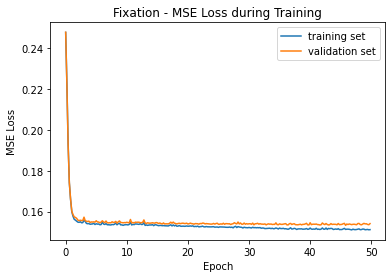

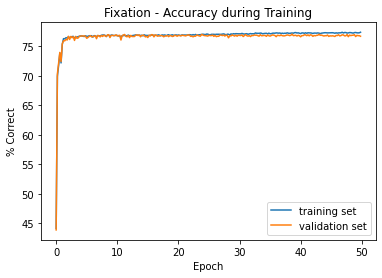

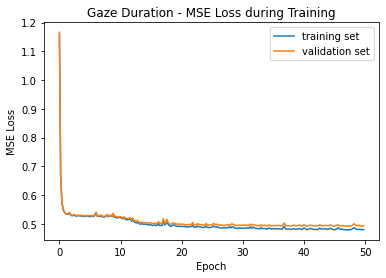

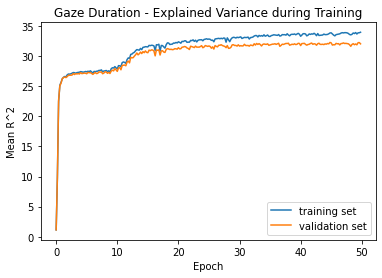

In [12]:
t = np.arange(0, num_epochs, 0.2)

plt.figure()
plt.title('Fixation - MSE Loss during Training')
plt.plot(t, fix_train_loss, label='training set')
plt.plot(t, fix_valid_loss, label='validation set')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
plt.title('Fixation - Accuracy during Training')
plt.plot(t, fix_train_acc, label='training set')
plt.plot(t, fix_valid_acc, label='validation set')
plt.ylabel('% Correct')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
plt.title('Gaze Duration - MSE Loss during Training')
plt.plot(t, dur_train_loss, label='training set')
plt.plot(t, dur_valid_loss, label='validation set')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
plt.title('Gaze Duration - Explained Variance during Training')
plt.plot(t, r2_train, label='training set')
plt.plot(t, r2_valid, label='validation set')
plt.ylabel('Mean R^2')
plt.xlabel('Epoch')
plt.legend()

In [13]:
test_me2(model, test_loader)

(tensor(76.9340),
 tensor(0.1520, grad_fn=<DivBackward0>),
 tensor(32.9364, grad_fn=<DivBackward0>),
 tensor(0.4850, grad_fn=<DivBackward0>))